# Trabalho 2

## 4.1.7 a)

Neste notebook está o código relativo à Regressão Linear Múltipla (sigla em inglês MLR).

### Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

import utilidades as ut

### Inicializações e variáveis

In [2]:
warnings.filterwarnings("ignore")  # Desabilitar warnings.
plt.style.use(
    "style/estilo.mplstyle")  # Garantir que se utiliza um estilo definido centralmente e comum a todos os gráficos.
%matplotlib inline

label_encoder = LabelEncoder()

ficheiro = "dados_preparados.csv"
ficheiro_resultados = "dados_resultados.csv"
colunas_numericas = ["Idade", "FCV", "NRP", "CA", "FAF", "TUDE", "IMC"]
colunas_classes = ["Genero", "Historico_obesidade_familiar", "FCCAC", "Fumador", "MCC", "CCER", "CBA", "TRANS"]
colunas_classes_binarias = ['Genero', 'Historico_obesidade_familiar', 'FCCAC', 'Fumador', 'MCC']
colunas_classes_multiplos = ["CCER", "CBA", "TRANS", "Label"]

## Leitura dos dados preparados

In [3]:
dados_trabalho = pd.read_csv(ficheiro)

In [4]:
dados_trabalho

,Genero,Idade,Historico_obesidade_familiar,FCCAC,FCV,NRP,CCER,Fumador,CA,MCC,FAF,TUDE,CBA,TRANS,Label,IMC
0,Feminino,21.000000,Sim,Nao,2.0,3.0,Ocasionalmente,Nao,2.000000,Nao,0.000000,1.000000,Nao,Transportes_Publicos,Peso_Normal,24.386526
1,Feminino,21.000000,Sim,Nao,3.0,3.0,Ocasionalmente,Sim,3.000000,Sim,3.000000,0.000000,Ocasionalmente,Transportes_Publicos,Peso_Normal,24.238227
2,Masculino,23.000000,Sim,Nao,2.0,3.0,Ocasionalmente,Nao,2.000000,Nao,2.000000,1.000000,Frequentemente,Transportes_Publicos,Peso_Normal,23.765432
3,Masculino,27.000000,Nao,Nao,3.0,3.0,Ocasionalmente,Nao,2.000000,Nao,2.000000,0.000000,Frequentemente,Caminhada,Excesso_Peso_Grau_I,26.851852
4,Masculino,22.000000,Nao,Nao,2.0,1.0,Ocasionalmente,Nao,2.000000,Nao,0.000000,0.000000,Ocasionalmente,Transportes_Publicos,Excesso_Peso_Grau_II,28.342381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Feminino,20.976842,Sim,Sim,3.0,3.0,Ocasionalmente,Nao,1.728139,Nao,1.676269,0.906247,Ocasionalmente,Transportes_Publicos,Obesidade_Mórbida,44.901475
2107,Feminino,21.982942,Sim,Sim,3.0,3.0,Ocasionalmente,Nao,2.005130,Nao,1.341390,0.599270,Ocasionalmente,Transportes_Publicos,Obesidade_Mórbida,43.741923
2108,Feminino,22.524036,Sim,Sim,3.0,3.0,Ocasionalmente,Nao,2.054193,Nao,1.414209,0.646288,Ocasionalmente,Transportes_Publicos,Obesidade_Mórbida,43.543817
2109,Feminino,24.361936,Sim,Sim,3.0,3.0,Ocasionalmente,Nao,2.852339,Nao,1.139107,0.586035,Ocasionalmente,Transportes_Publicos,Obesidade_Mórbida,44.071535


Temos no entanto de realizar primeiro o encoding das classes para valores numéricos, esta operação é realizada usando o ``sklearn.preprocessing.LabelEncoder`` em todas as colunas com apenas 2 classes.

In [5]:
ut.titulo("Valores codificados por atributo")

# for coluna in colunas_classes_binarias:
for coluna in colunas_classes:
    if dados_trabalho[coluna].dtype == 'object':
        dados_trabalho[coluna] = label_encoder.fit_transform(dados_trabalho[coluna].values)
        ut.etiqueta_e_valor(coluna, str(sorted(dados_trabalho[coluna].unique())))

Valores codificados por atributo
Genero: [0, 1]
Historico_obesidade_familiar: [0, 1]
FCCAC: [0, 1]
Fumador: [0, 1]
MCC: [0, 1]
CCER: [0, 1, 2, 3]
CBA: [0, 1, 2, 3]
TRANS: [0, 1, 2, 3, 4]


A coluna *Label* é uma "classificação", não um preditor. Tem de ser removida.

In [6]:
dados_trabalho.drop("Label", axis=1, inplace=True)

| Target | Preditores                   |
|--------|------------------------------|
| IMC    | Todas os restantes atributos |

O target não muda

In [7]:
y = dados_trabalho.IMC

## Preditores

Colunas originais, antes do get_dummies:
lista_preditores = ["Idade", "Genero", "Historico_obesidade_familiar", "FCCAC", "FCV", "NRP", "CCER", "Fumador", "CA", "MCC", "FAF", "TUDE", "CBA", "TRANS"]

Obter a lista de todos os atributos (preditores) do dataset, é preciso remover a coluna "IMC"

In [8]:
lista_preditores = list(dados_trabalho.columns.values)
lista_preditores.remove("IMC")

X = dados_trabalho.drop("IMC", axis=1)

### Holdout

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

## Cálculo

### Inicializar o algoritmo


In [10]:
mlr = LinearRegression()

### Fit the data

In [11]:
mlr.fit(X_train, y_train)

LinearRegression()

### Previsão 

In [12]:
y_prev_mlr = mlr.predict(X_test)

ut.titulo("Previsão para o conjunto de teste:")
print(y_prev_mlr)

Previsão para o conjunto de teste:
[29.40864238 35.10087688 37.16001434 29.26109743 34.81626866 26.88565374
 31.8091044  14.3092412  13.35485012 31.17669077 30.08471775 22.08893582
 29.0450051  35.96192224 20.40491792 28.13784389 24.83251076 36.47959734
 34.51555357 29.16291055 31.70481489 32.58473034 22.22324051 21.07908517
 30.70152622 32.691603   29.34602568 34.5028433  16.87447573 36.76011375
 32.02710422 32.97125397 31.05936852 37.39429498 26.34416855 33.9935454
 30.33009378 32.23290741 28.86265947 31.83838642 34.93507687 34.51803133
 34.93466577 16.13978067 22.56136838 18.78261264 29.66308537 30.74265931
 29.02284208 33.6269103  31.31598805 25.06057405 27.69464812 29.26493866
 31.14616639 30.23030488 30.44337008 37.86757981 20.89703076 27.44115936
 33.12251857 37.61923521 30.14611578 17.32650291 20.79145414 30.93682095
 31.53185288 31.69327639 32.68520685 37.94312378 29.81204501 31.6957131
 33.85675025 34.08279666 23.10460564 31.55042556 34.74252769 34.65519188
 37.8105066  37.95

# Valores reais e valores previstos

In [13]:
mlr_diff = pd.DataFrame({"Valor Real": y_test, "Valor previsto": y_prev_mlr})
mlr_diff.head()

,Valor Real,Valor previsto
785,25.269124,29.408642
1838,47.718705,35.100877
2083,40.870732,37.160014
1105,29.146663,29.261097
361,32.873110,34.816269


### Avaliação do Modelo

#### Métricas dos dados de teste

In [14]:
mae = metrics.mean_absolute_error(y_test, y_prev_mlr)
mse = metrics.mean_squared_error(y_test, y_prev_mlr)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_prev_mlr))

ut.titulo("Métricas nos valores de Teste")
ut.etiqueta_e_valor("R squared:", f"{(mlr.score(X, y) * 100):.5}")
ut.etiqueta_e_valor("Mean Absolute Error:", f"{mae:.5}")
ut.etiqueta_e_valor("Mean Square Error:", f"{mse:.5}")
ut.etiqueta_e_valor("Root Mean Square Error:", f"{rmse:.5}")

Métricas nos valores de Teste
R squared:: 47.835
Mean Absolute Error:: 4.5282
Mean Square Error:: 31.935
Root Mean Square Error:: 5.6511


#### Métricas dos dados de treino

In [15]:
y_prev_treino = mlr.predict(X_train)
mae = metrics.mean_absolute_error(y_train, y_prev_treino)
mse = metrics.mean_squared_error(y_train, y_prev_treino)
rmse = np.sqrt(metrics.mean_squared_error(y_train, y_prev_treino))

ut.titulo("Métricas nos valores de Treino")
ut.etiqueta_e_valor("R squared:", f"{(mlr.score(X, y) * 100):.5}")
ut.etiqueta_e_valor("Mean Absolute Error:", f"{mae:.5}")
ut.etiqueta_e_valor("Mean Square Error:", f"{mse:.5}")
ut.etiqueta_e_valor("Root Mean Square Error:", f"{rmse:.5}")

Métricas nos valores de Treino
R squared:: 47.835
Mean Absolute Error:: 4.6729
Mean Square Error:: 33.848
Root Mean Square Error:: 5.8179


### Cálculo dos resíduos

In [16]:
mlr_diff["residuos"] = y_test - y_prev_mlr

### Teste normalidade dos resíduos

In [17]:
normalidade_residuos = stats.shapiro(mlr_diff.residuos)
print(f"pvalue: {normalidade_residuos.pvalue:.3}")

pvalue: 0.766


### QQ-Plot

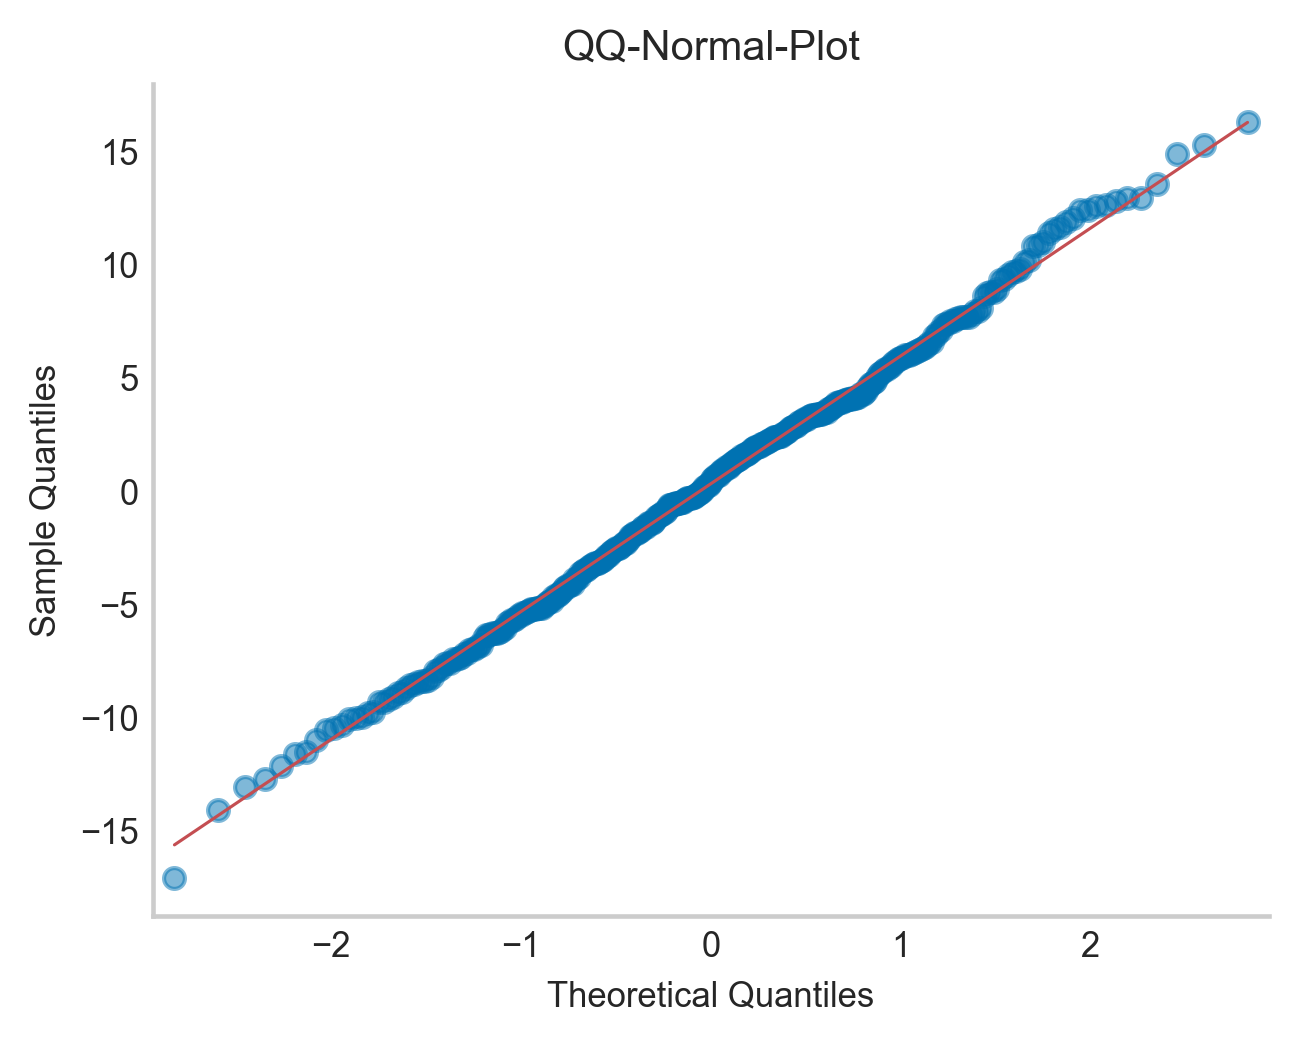

In [18]:
sm.qqplot(mlr_diff["residuos"], line='s', markersize=5, alpha=0.5)
plt.title('QQ-Normal-Plot')
plt.show()

### Multicolinearidade: Fator de inflação de variância (VIF)

In [19]:
vif_residuos = pd.DataFrame()
vif_residuos["variaveis"] = X_test.columns
vif_residuos["VIF"] = [variance_inflation_factor(X_test, i) for i in range(len(vif_residuos["variaveis"]))]
print(vif_residuos)

                       variaveis        VIF
0                         Genero   2.310087
1                          Idade  18.084201
2   Historico_obesidade_familiar   7.215442
3                          FCCAC   8.859644
4                            FCV  20.130236
5                            NRP  12.128220
6                           CCER   9.345850
7                        Fumador   1.049434
8                             CA  11.566252
9                            MCC   1.189818
10                           FAF   2.647346
11                          TUDE   2.545449
12                           CBA  11.994997
13                         TRANS   5.878640
